In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib

In [2]:
trees = pd.read_csv('national_tes.csv')
transpo = pd.read_csv('PublicTranspo.csv')
happiness = pd.read_csv("CityHappiness.csv")
housing = pd.read_csv("housing.csv")
states = pd.read_csv("states.csv")

In [3]:
trees["place_name"] = trees["place"] + ", " + trees["state_abbr"]
housing = pd.merge(states, housing, on='State', how='right')
housing["city"] = housing["City"] + ", " + housing["Abbreviation"]

In [4]:
tree_cover = trees.groupby("place_name").apply(lambda g: (g["land_area"] * g["treecanopy"] ).sum() / g["land_area"].sum()).reset_index()
tree_cover.columns = ['place_name', 'tree_cover']

<ipython-input-4-0ec7b7334dd6>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tree_cover = trees.groupby("place_name").apply(lambda g: (g["land_area"] * g["treecanopy"] ).sum() / g["land_area"].sum()).reset_index()


In [5]:
median_housing = housing.groupby('city')['Price'].median().reset_index()
median_housing.columns = ['city', 'median_home']
income = housing.groupby('city')['Median Household Income'].median().reset_index()
income.columns = ['city', 'median_income']

,city,median_income
0,"Albuquerque, NM",80731.0
1,"Aledo, TX",177226.0
2,"Apache Junction, AZ",68960.0
3,"Arlington, TX",110896.0
4,"Arverne, NY",88642.0
...,...,...
242,"Wilmington, CA",79140.0
243,"Winnetka, CA",108101.0
244,"Woodland Hills, CA",140415.0
245,"Woodside, NY",98608.0


In [61]:
df = pd.merge(tree_cover, transpo, left_on='place_name', right_on='Name', how='left')
df = pd.merge(df, happiness, left_on='Name', right_on='City', how='left')
df = pd.merge(df, median_housing, left_on='Name', right_on='city', how='left')
df = pd.merge(df, income, left_on='Name', right_on='city', how='left')

df_drop_na = df.dropna(axis=0).reset_index()
df_cleaned = df_drop_na[["City", "median_income", "median_home", "tree_cover", "Score", "Emotional & Physical Well-Being Rank"]]
df_cleaned['home_income_power'] =  df_cleaned['median_home'] / df_cleaned['median_income']
df_cleaned["Emotional & Physical Well-Being Rank"] = 183 - df_cleaned["Emotional & Physical Well-Being Rank"]
df_cleaned.columns = ['city', 'median_income', 'median_home', 'tree_cover', 'transpo_score', 'wellbeing_rank', 'home_income_power']

<ipython-input-61-a4eef1c38a3f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['home_income_power'] =  df_cleaned['median_home'] / df_cleaned['median_income']
<ipython-input-61-a4eef1c38a3f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["Emotional & Physical Well-Being Rank"] = 183 - df_cleaned["Emotional & Physical Well-Being Rank"]


In [63]:
top5 = df_cleaned.sort_values('transpo_score', ascending=False).head(5)
top5

,city,median_income,median_home,tree_cover,transpo_score,wellbeing_rank,home_income_power
28,"New York, NY",224663.0,762450.0,0.224917,9.6,120.0,3.393750
40,"San Francisco, CA",201841.0,1295000.0,0.172897,9.3,180.0,6.415941
6,"Chicago, IL",104720.0,349900.0,0.199477,9.2,127.0,3.341291
33,"Philadelphia, PA",77163.0,264950.0,0.252232,9.1,27.0,3.433640
46,"Washington, DC",147338.0,675000.0,0.372779,9.1,165.0,4.581303


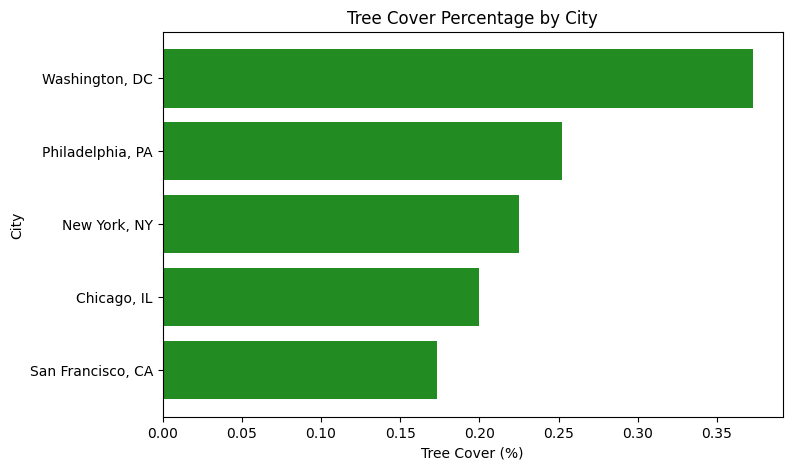

In [83]:
df = top5.sort_values(by='tree_cover', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(df['city'], df['tree_cover'], color='forestgreen')

# Labels and title
plt.xlabel('Tree Cover (%)')
plt.ylabel('City')
plt.title('Tree Cover Percentage by City')
plt.gca().invert_yaxis()  # Highest-ranking city at the top

plt.savefig("treecover.png", bbox_inches="tight", dpi=300)  # High resolution

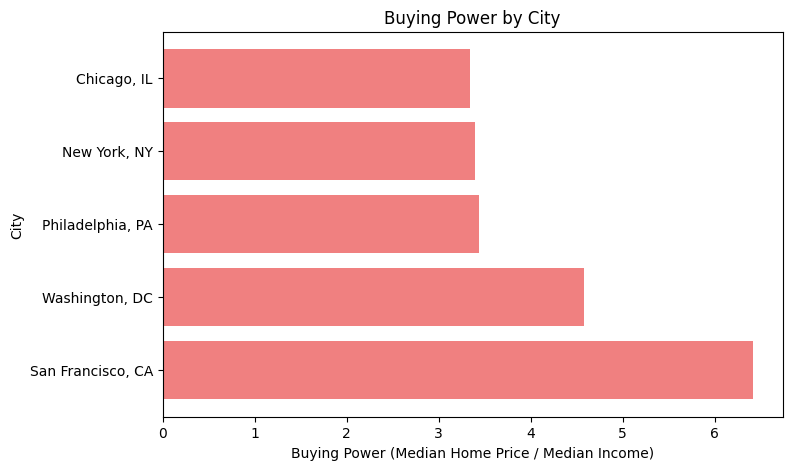

In [88]:
df = top5.sort_values(by='home_income_power', ascending=True)


# Plot
plt.figure(figsize=(8, 5))
plt.barh(df['city'], df['home_income_power'], color='lightcoral')

# Labels and title
plt.xlabel('Buying Power (Median Home Price / Median Income)')
plt.ylabel('City')
plt.title('Buying Power by City')
plt.gca().invert_yaxis()  # Highest-ranking city at the top
plt.rcParams["axes.formatter.limits"] = (-10000000, 1000000)


plt.savefig("buyingpower.png", bbox_inches="tight", dpi=300)  # High resolution

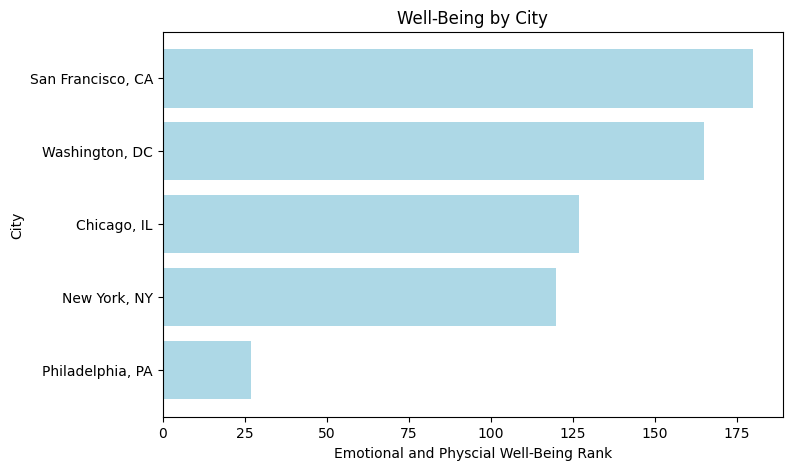

In [85]:
df = top5.sort_values(by='wellbeing_rank', ascending=False)


# Plot
plt.figure(figsize=(8, 5))
plt.barh(df['city'], df['wellbeing_rank'], color='lightblue')

# Labels and title
plt.xlabel('Emotional and Physcial Well-Being Rank')
plt.ylabel('City')
plt.title('Well-Being by City')
plt.gca().invert_yaxis()  # Highest-ranking city at the top
plt.rcParams["axes.formatter.limits"] = (-10000000, 1000000)

plt.savefig("wellbeing.png", bbox_inches="tight", dpi=300)  # High resolution

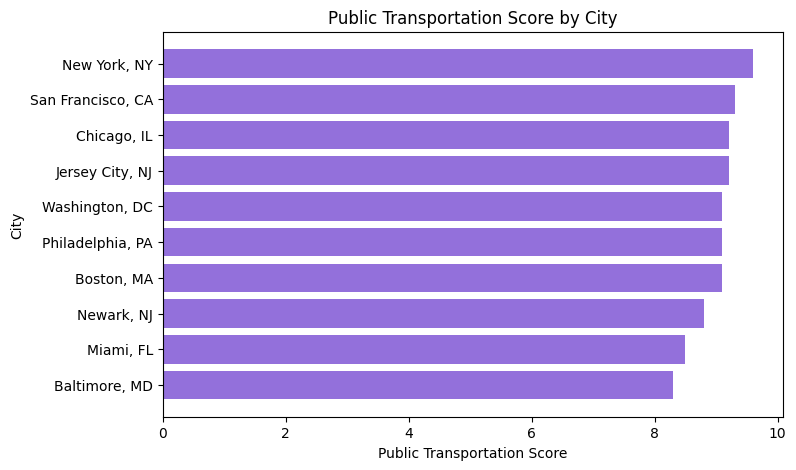

In [86]:
df = transpo.sort_values('Score', ascending=False).head(10)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(df['Name'], df['Score'], color='mediumpurple')

# Labels and title
plt.xlabel('Public Transportation Score')
plt.ylabel('City')
plt.title('Public Transportation Score by City')
plt.gca().invert_yaxis()  # Highest-ranking city at the top
plt.rcParams["axes.formatter.limits"] = (-10000000, 1000000)


plt.savefig("transpo.png", bbox_inches="tight", dpi=300)  # High resolution

In [87]:
X = df_cleaned[['transpo_score']]       # Selecting independent variables
X = sm.add_constant(X)        # Adds a constant (intercept)
Y = df_cleaned['wellbeing_rank']                # Dependent variable

model = sm.OLS(Y, X).fit()  # Fit the model

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         wellbeing_rank   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     8.589
Date:                Thu, 13 Feb 2025   Prob (F-statistic):            0.00525
Time:                        20:54:51   Log-Likelihood:                -251.32
No. Observations:                  48   AIC:                             506.6
Df Residuals:                      46   BIC:                             510.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            43.8455     19.576      2.240